In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
class Material:
    name: str
    nuc_rho: float
    sigma_c: float
    sigma_s: float
    ksi: float

    def __init__(self, name: str, nuc_rho, sigma_c, sigma_s, ksi) -> None:
        self.name = name
        self.nuc_rho = nuc_rho
        self.sigma_c = sigma_c
        self.sigma_s = sigma_s
        self.ksi = ksi

In [40]:
H2_O = Material('вода', 0.026, 0.66, 63, 0.948)
D2_O = Material('тяжёлая вода', 0.026, 0.001, 13.6, 0.57)
Zr = Material('цирконий', 0.043, 0.185, 8, 0.022)
Fe = Material('железо', 0.084, 2.62, 11.4, 0.035)
C = Material('графит', 0.085, 0.004, 4.8, 0.158)
U_02 = Material('оксид урана', 0.024, 0, 0, 0)

In [41]:
H2_O = Material('$H_{2}O$', 0.026, 0.66, 63, 0.948)
D2_O = Material('$D_{2}O$', 0.026, 0.001, 13.6, 0.57)
Zr = Material('Zr', 0.043, 0.185, 8, 0.022)
Fe = Material('Fe', 0.084, 2.62, 11.4, 0.035)
C = Material('C', 0.085, 0.004, 4.8, 0.158)
U_02 = Material('$UO_{2}$', 0.024, 0, 0, 0)

In [42]:
U235 = {"sigma_f": 580.2, "sigma_c": 98.3, "sigma_s": 17.6, "nu_f": 2.49}
U238 = {"sigma_c": 2.71, "sigma_s": 9}

In [43]:
class Reactor:
    eps_t: float
    eps_th: float
    eps_zr: float
    eps_c: float

    def __init__(self, eps_t: float, eps_th: float, eps_zr: float, eps_c: float) -> None:
        self.eps_t = eps_t
        self.eps_th = eps_th
        self.eps_zr = eps_zr
        self.eps_c = eps_c

In [44]:
rbmk = Reactor(0.0316, 0.038, 0.0272, 0.9)
vver = Reactor(0.002, 0.9974, 0.002, 0)

In [45]:
mu = 1
X = [0.00714, 0.01, 0.02, 0.03, 0.04, 0.05]
Eta = [U235["nu_f"] * U235["sigma_f"] /
       (U235["sigma_f"] + U235["sigma_c"] + U238["sigma_c"]/x) for x in X]
Eta

[1.3654321760966,
 1.521535545023697,
 1.7748132678132682,
 1.8790782570995017,
 1.9359437185929653,
 1.9717455984714074]

In [46]:
def calc_sigma_at(X, reactor: Reactor) -> list:
    return [((U235['sigma_f'] + U235['sigma_c']) * x + U238['sigma_c']) * U_02.nuc_rho * reactor.eps_t for x in X]


def calc_sigma_az(mat: Material = C) -> float:
    return mat.sigma_c * mat.nuc_rho * rbmk.eps_c


def calc_sigma_ath(mat: Material = H2_O) -> float:
    return mat.nuc_rho * mat.sigma_c * rbmk.eps_th


def calc_sigma_ak(mat: Material = Zr) -> float:
    return mat.nuc_rho * mat.sigma_c * rbmk.eps_zr


def calc_tetta(X, reactor: Reactor, mat_slow: Material = C, mat_ath: Material = H2_O, mat_ak: Material = Zr) -> list:
    Sigma_at = calc_sigma_at(X, reactor)
    sigma_az = calc_sigma_az(mat_slow)
    sigma_ath = calc_sigma_ath(mat_ath)
    sigma_ak = calc_sigma_ak(mat_ak)

    return [sigma_at / (sigma_az + sigma_ath + sigma_ak + sigma_at) for sigma_at in Sigma_at]


def calc_I(reactor: Reactor, mat_slow: Material) -> float:
    return 3.8 * (U238['sigma_s'] + mat_slow.nuc_rho * reactor.eps_c * mat_slow.sigma_s / U_02.nuc_rho / reactor.eps_t) ** 0.42


def calc_phi(reactor: Reactor, mat_slow: Material) -> float:
    I = calc_I(reactor, mat_slow)
    return np.exp(-U_02.nuc_rho * reactor.eps_t * I / (mat_slow.ksi * mat_slow.sigma_s * reactor.eps_c * mat_slow.nuc_rho))

# X, доли веществ в ячейке, материал замедлителя, материал теплоносителя, материал конструкции


def calc_k(X, reactor: Reactor, mat_slow: Material = C, mat_ath: Material = H2_O, mat_ak: Material = Zr) -> list:
    Tetta = calc_tetta(X, reactor, mat_slow, mat_ath, mat_ak)
    phi = calc_phi(reactor, mat_slow)

    return [mu * eta * tetta * phi for (tetta, eta) in zip(Tetta, Eta)]

In [47]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


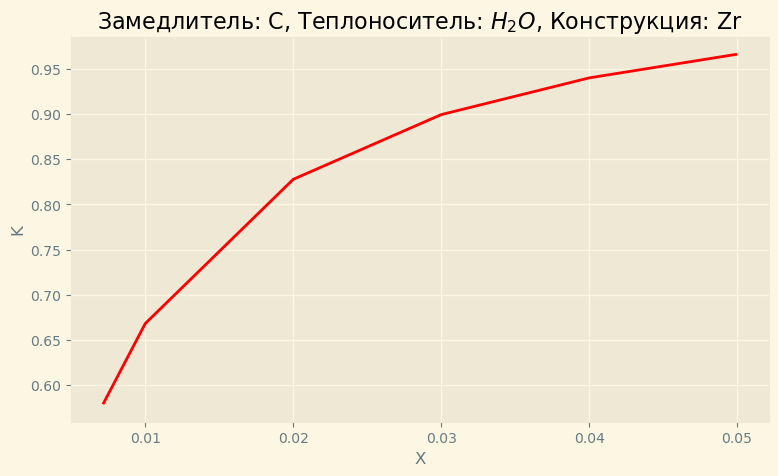

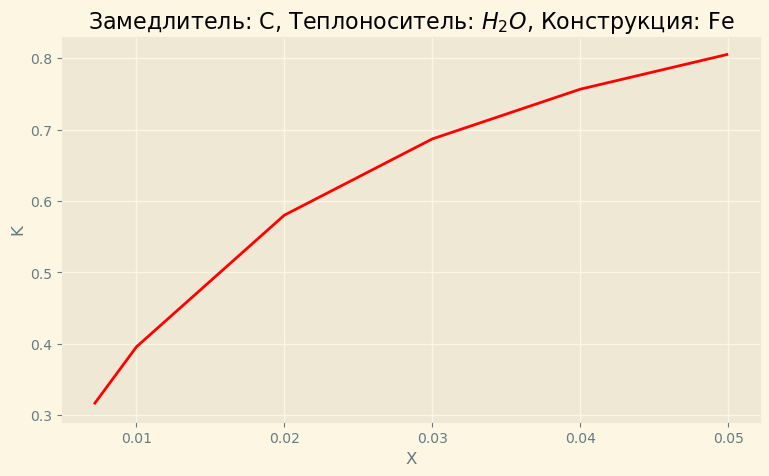

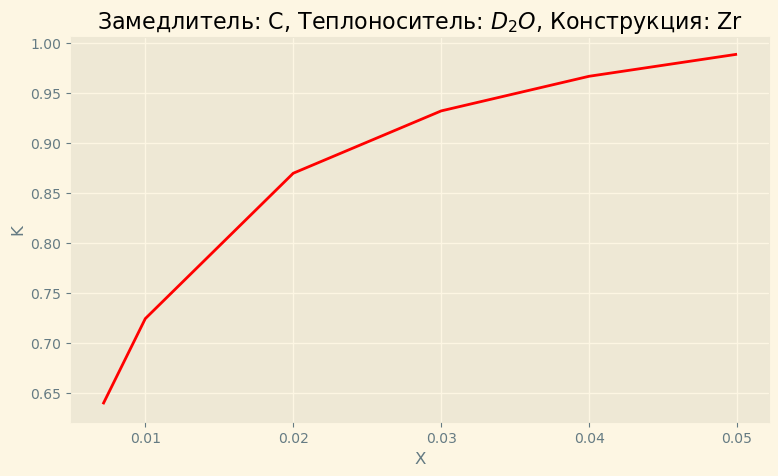

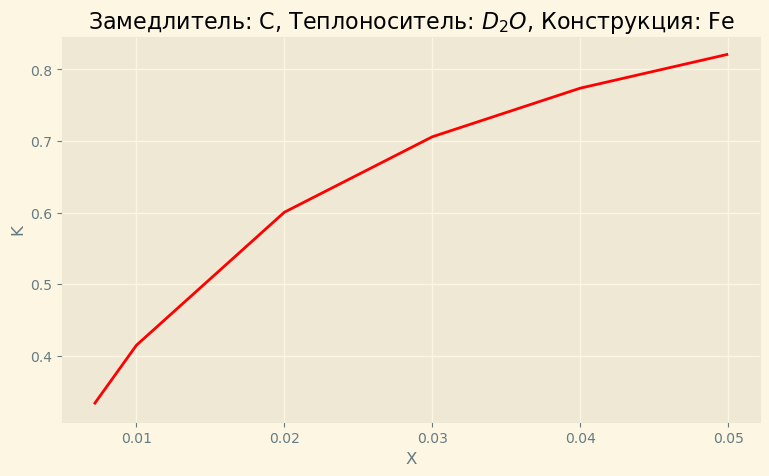

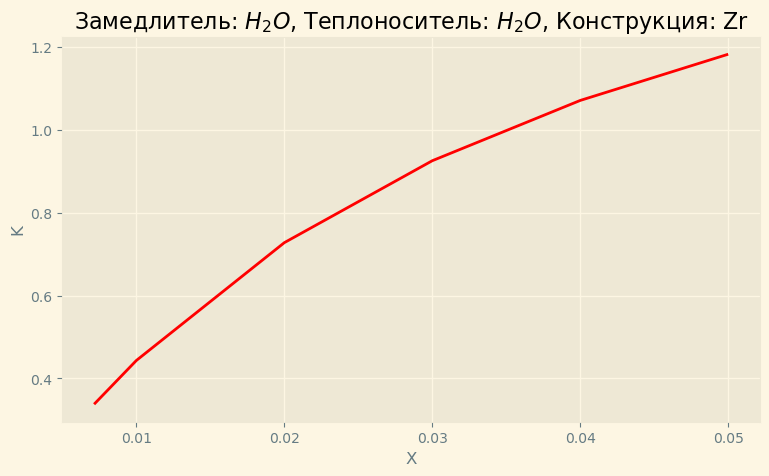

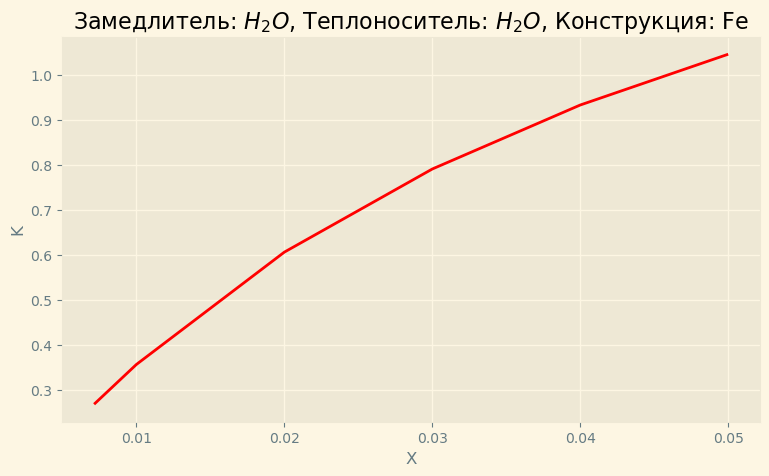

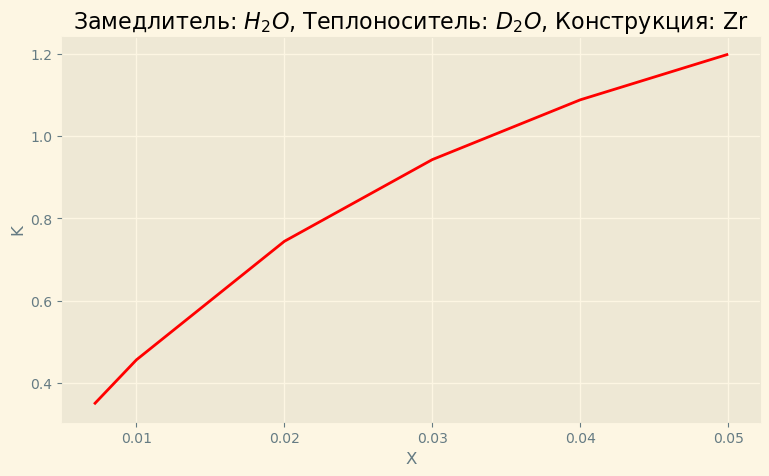

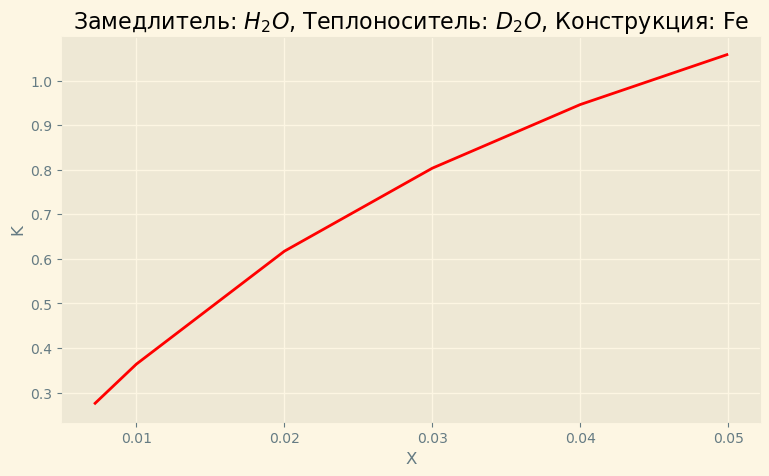

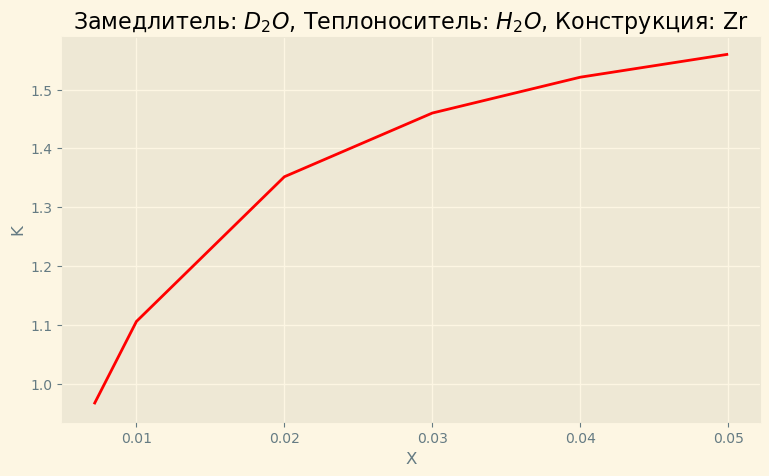

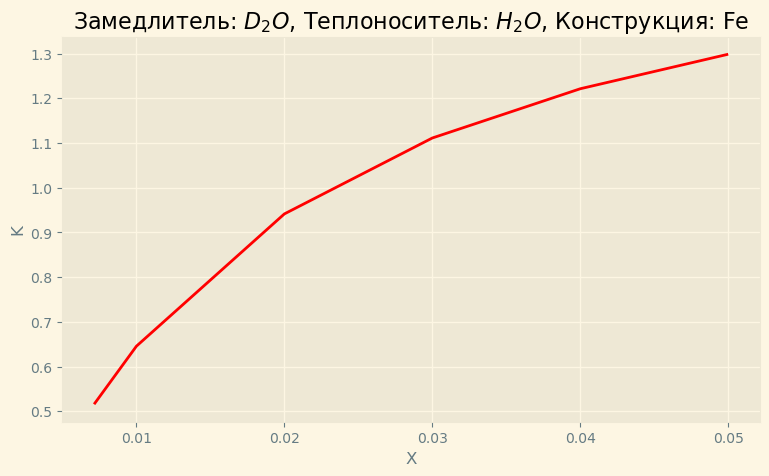

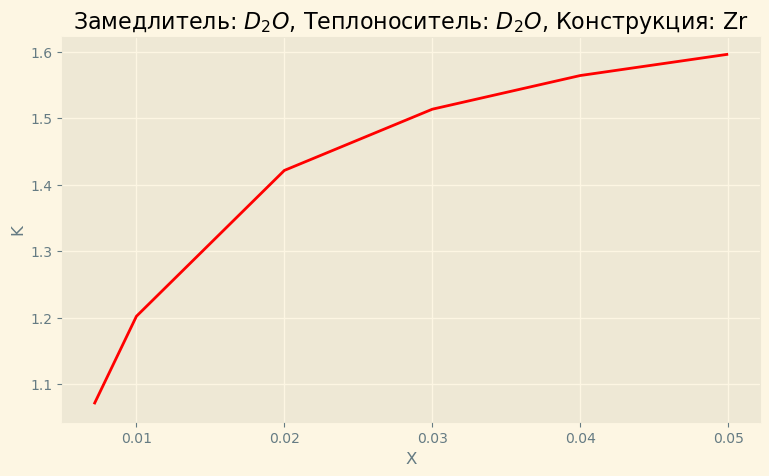

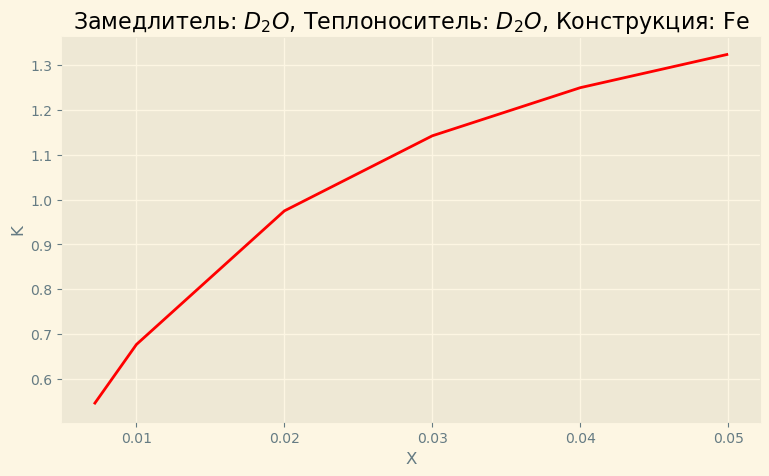

In [48]:
success = []
for mat_slow in [C, H2_O, D2_O]:
    for mat_ath in [H2_O, D2_O]:
        for mat_ak in [Zr, Fe]:
            K = calc_k(X, rbmk, mat_slow, mat_ath, mat_ak)
            if K[-1] > 1.05:
                success.append(
                    f'{K[-1]}: Замедлитель: {mat_slow.name}, Теплоноситель: {mat_ath.name}, Конструкция: {mat_ak.name}')
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(9, 5))
            plt.title(
                f'Замедлитель: {mat_slow.name}, Теплоноситель: {mat_ath.name}, Конструкция: {mat_ak.name}')
            plt.plot(X, K, color='r')
            plt.xlabel('X')
            plt.ylabel('K')
            plt.grid(True)
            plt.show()

In [49]:
success

['1.1821033783006436: Замедлитель: $H_{2}O$, Теплоноситель: $H_{2}O$, Конструкция: Zr',
 '1.199818924112005: Замедлитель: $H_{2}O$, Теплоноситель: $D_{2}O$, Конструкция: Zr',
 '1.0591566380138009: Замедлитель: $H_{2}O$, Теплоноситель: $D_{2}O$, Конструкция: Fe',
 '1.560144456003794: Замедлитель: $D_{2}O$, Теплоноситель: $H_{2}O$, Конструкция: Zr',
 '1.2988132256288991: Замедлитель: $D_{2}O$, Теплоноситель: $H_{2}O$, Конструкция: Fe',
 '1.5963909041127446: Замедлитель: $D_{2}O$, Теплоноситель: $D_{2}O$, Конструкция: Zr',
 '1.3238364009855033: Замедлитель: $D_{2}O$, Теплоноситель: $D_{2}O$, Конструкция: Fe']

In [50]:
calc_k(X, rbmk, D2_O, H2_O)

[0.9648808650652045,
 1.105627199400653,
 1.3517570063937792,
 1.4601043147102004,
 1.5210631625897946,
 1.560144456003794]